In [1]:
import pandas as pd
import altair as alt

In [2]:
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [3]:
irradiance_df = pd.read_csv("data/irradiance.csv")

In [4]:
# show first five rows
irradiance_df.head()

,device_id,timestamp,irradiance
0,9,2024-06-01 00:00:00,0
1,9,2024-06-01 01:00:00,0
2,9,2024-06-01 02:00:00,0
3,9,2024-06-01 03:00:00,0
4,9,2024-06-01 04:00:00,0


## Basic interpolation

> See [pandas docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)

### Reshape data for interpolation

In [5]:
df = irradiance_df.copy()

# ensure proper data type
df['timestamp'] =  pd.to_datetime(df['timestamp'])

# ensure we just have a single device, then drop device column
df[df['device_id'] == 9]
df = df[['timestamp', 'irradiance']]

# set index to timestamp and 
df = df.set_index('timestamp').sort_index()

# resample so we have one entry for every hour
df_hourly = df.resample('1h').asfreq()

# add column to indicate if data was missing
df_hourly['missing'] = df_hourly['irradiance'].isna()

In [6]:
# preview some rows
df_hourly.iloc[35:40]

,irradiance,missing
timestamp,,
2024-06-02 11:00:00,NaN,True
2024-06-02 12:00:00,NaN,True
2024-06-02 13:00:00,964.0,False
2024-06-02 14:00:00,851.0,False
2024-06-02 15:00:00,NaN,True


### Run interpolation function

In [7]:
df_interpolated = df_hourly.interpolate(method='time')
df_interpolated.iloc[35:40]

,irradiance,missing
timestamp,,
2024-06-02 11:00:00,857.50,True
2024-06-02 12:00:00,910.75,True
2024-06-02 13:00:00,964.00,False
2024-06-02 14:00:00,851.00,False
2024-06-02 15:00:00,703.00,True


### Make plot

#### Quick plot

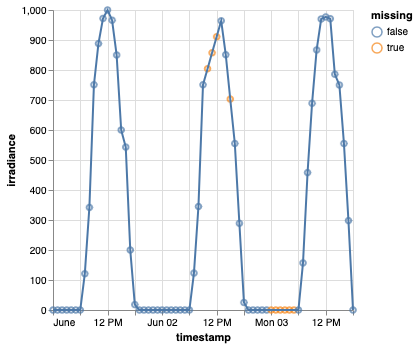

In [8]:
line = alt.Chart(df_interpolated.reset_index()).mark_line().encode(
    x='timestamp:T',
    y='irradiance:Q',
)

points = alt.Chart(df_interpolated.reset_index()).mark_point().encode(
    x='timestamp:T',
    y='irradiance:Q',
    color="missing",
)

points + line

#### Fancy plot

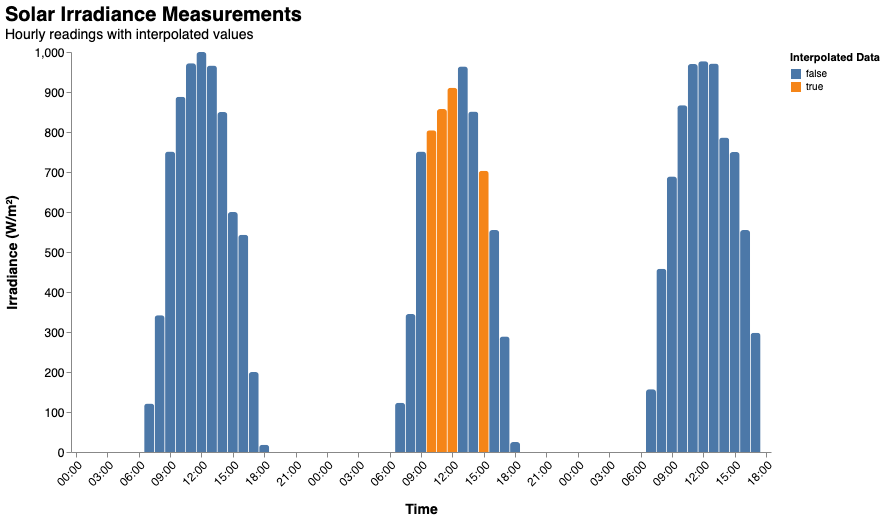

In [9]:
alt.Chart(df_interpolated.reset_index()).mark_bar(
    cornerRadiusTopLeft=3, cornerRadiusTopRight=3, width=10
).encode(
    x=alt.X(
        "timestamp:T",
        title="Time",
        axis=alt.Axis(labelAngle=-45, format="%H:%M", grid=False),
    ),
    y=alt.Y("irradiance:Q", title="Irradiance (W/m²)"),
    color=alt.Color(
        "missing:N",
        legend=alt.Legend(title="Interpolated Data"),
    ),
).properties(
    width=700,
    height=400,
    title={
        "text": "Solar Irradiance Measurements",
        "subtitle": "Hourly readings with interpolated values",
        "fontSize": 20,
        "subtitleFontSize": 14,
        "anchor": "start",
    },
).configure_view(
    strokeWidth=0
).configure_axis(
    labelFontSize=12, titleFontSize=14, titlePadding=15, grid=False
).configure_title(
    fontSize=20
)

### Sum irradiance

Sum the irradiance values for each day

In [10]:
daily_sums = df_interpolated.resample('D')['irradiance'].sum()
pd.DataFrame(daily_sums)

,irradiance
timestamp,
2024-06-01,7251.0
2024-06-02,7178.5
2024-06-03,7478.0
